In [34]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

We can load the images from the disk using just a few lines of code using the tf.keras.utils.image_dataset_from_directory utility. This will take you from a directory of images on a disk to a tf.data.Dataset. 

In [35]:
data_dir = "/Users/esbishop/Sea_snakes_images/Images"   # Path to image directory

In [36]:
# We need to define some parameters for the laoder: 
batch_size = 32
img_height = 180
img_width = 180

In [37]:
# It's good practice to use a validation split when developing a model. Let's use 80% of the images for training, 
# and 20% for validation. 
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1370 files belonging to 2 classes.
Using 1096 files for training.


In [38]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1370 files belonging to 2 classes.
Using 274 files for validation.


In [39]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory = "/Users/esbishop/Sea_snakes_images/test_images",
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 314 files belonging to 2 classes.


In [40]:
# We can have a look at the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order. 
class_names = train_ds.class_names
print(class_names)

['rope', 'snake']


2022-01-19 10:50:02.981862: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-19 10:50:02.983322: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


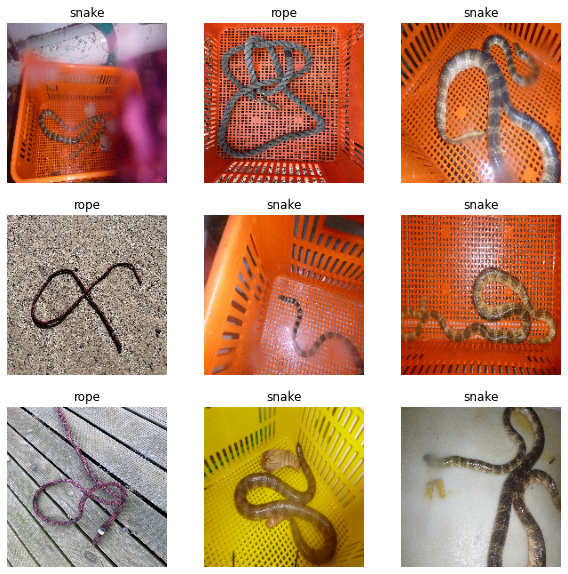

In [8]:
# We can have a look at the first 9 images from the training dataset: 

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
# We will train a model using these datasets by passing them to Model.fit. We can also manually iterate over the 
# dataset and retreive batches on images:

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [22]:
for image_batch, labels_batch in test_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


### Configure the Dataset for performance

Let's make sure to use buffered prefetching so you can yeild data from disk without haveing I/O become blocking. These are two important methods you should use when loading data: 
- Dataset.cache keeps the images in memory after theyre loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training the model. If your dataset is too large to fit in memory, you can also use this method to create a performant on-disk cache. 
- Dataset.prefetch overlaps data preprocessing and model execution while training. 

In [41]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Standardise the data 

The RGB colour channels are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. 

Here, we will standardise values to be in the [0,1] range by using tf.keras.layers.Rescaling

In [42]:
normalization_layer = layers.Rescaling(1./255) # We can include this layer in the model definition 

In [43]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='sigmoid'),  # using a sigmoid activation function as this is a binary classification problem with one node as per https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/
  layers.Dense(num_classes)
])

### Compile the model

We choose the tf.keras.optimizers.Adam optimiser and tf.keras.losses.SparseCategoricalCrossentropy loss function. To view training and validation accuracy for each training epoch, pass the metrics argument to Model.compile. 

In [44]:
model.compile(optimizer='adam',      # 'adam' is an adaptive optimiser which is good with sparse datasets 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # computes crossentropy loss between labels and predictions. Use when there are two or more label classes are integers rather than binary or one-hot encoded. 
              metrics=['accuracy'])

In [45]:
# View all layers of the network using the model's Model.summary method: 

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)       

### Train the model

In [46]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


2022-01-19 14:08:17.811964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-19 14:08:27.975529: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 248 of 256
2022-01-19 14:08:27.975612: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
2022-01-19 14:08:29.795051: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1 of 1000
2022-01-19 14:08:38.841206: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 8 of 1000
2022-01-19 14:08:49.161684: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 16 of 1000
2022-01-19 14:08:58.893852: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 24 of 100

 1/35 [..............................] - ETA: 24:54 - loss: 0.8326 - accuracy: 0.3750

2022-01-19 14:09:01.416885: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


35/35 [==============================] - ETA: 0s - loss: 0.7337 - accuracy: 0.7473

2022-01-19 14:09:04.223622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-19 14:09:14.274522: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 246 of 256
2022-01-19 14:09:14.578592: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


35/35 [==============================] - 58s 415ms/step - loss: 0.7337 - accuracy: 0.7473 - val_loss: 0.1525 - val_accuracy: 0.9380
Epoch 2/20
35/35 [==============================] - 3s 75ms/step - loss: 0.1551 - accuracy: 0.9407 - val_loss: 0.1206 - val_accuracy: 0.9416
Epoch 3/20
35/35 [==============================] - 3s 72ms/step - loss: 0.1429 - accuracy: 0.9480 - val_loss: 0.1425 - val_accuracy: 0.9562
Epoch 4/20
35/35 [==============================] - 3s 72ms/step - loss: 0.0915 - accuracy: 0.9745 - val_loss: 0.0908 - val_accuracy: 0.9708
Epoch 5/20
35/35 [==============================] - 3s 73ms/step - loss: 0.0541 - accuracy: 0.9790 - val_loss: 0.0520 - val_accuracy: 0.9854
Epoch 6/20
35/35 [==============================] - 2s 71ms/step - loss: 0.1076 - accuracy: 0.9626 - val_loss: 0.0651 - val_accuracy: 0.9781
Epoch 7/20
35/35 [==============================] - 2s 70ms/step - loss: 0.0473 - accuracy: 0.9854 - val_loss: 0.0625 - val_accuracy: 0.9708
Epoch 8/20
35/35 [====

### Visulaise the training results

Create plots of loss and accuracy on the training and validation sets: 

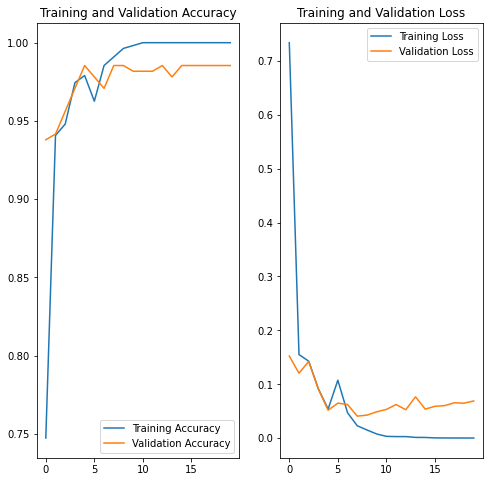

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [48]:
# Evaluate the model accuracy on test set 
test_model = keras.models.load_model(
            "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_ds) 
print(f"Test accuracy: {test_acc:.3f}")

2022-01-19 14:10:16.107277: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 13s 490ms/step - loss: 0.3383 - accuracy: 0.9204
Test accuracy: 0.920


In [24]:
#print(dir())

['AUTOTUNE', 'In', 'Out', 'PIL', 'Sequential', '_', '__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__package__', '__spec__', '_dh', '_i', '_i1', '_i10', '_i11', '_i12', '_i13', '_i14', '_i15', '_i16', '_i17', '_i18', '_i19', '_i2', '_i20', '_i21', '_i22', '_i23', '_i24', '_i3', '_i4', '_i5', '_i6', '_i7', '_i8', '_i9', '_ih', '_ii', '_iii', '_oh', 'acc', 'ax', 'batch_size', 'class_names', 'data_dir', 'epochs', 'epochs_range', 'exit', 'get_ipython', 'history', 'i', 'image_batch', 'images', 'img_height', 'img_width', 'keras', 'labels', 'labels_batch', 'layers', 'loss', 'model', 'normalization_layer', 'np', 'num_classes', 'os', 'plt', 'quit', 'tf', 'train_ds', 'val_acc', 'val_ds', 'val_loss']


In [25]:
#for element in dir():
#    if element[0:2] != "__":
#        del globals()[element]

#del element
#print(dir())

['__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__package__', '__spec__']


### Data augmentation:
Augment the data by horizontally flipping it, rotating it, and zooming it. 

In [49]:
with tf.device('/CPU:0'):
    data_augmentation = keras.Sequential(
      [
        layers.RandomFlip("horizontal",
                          input_shape=(img_height,
                                      img_width,
                                      3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
      ]
    )

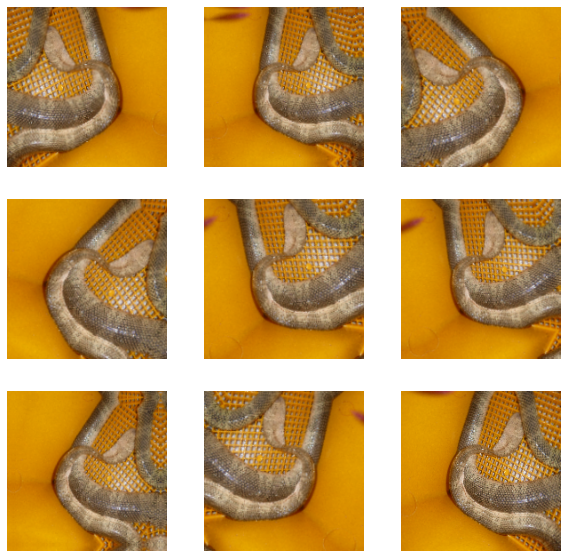

In [50]:
with tf.device('/CPU:0'):
    plt.figure(figsize=(10, 10))
    for images, _ in train_ds.take(1):
        for i in range(9):
            augmented_images = data_augmentation(images)
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(augmented_images[0].numpy().astype("uint8"))
            plt.axis("off")
 

### Dropout
Another technique to reduce overfitting is to introduce dropout regularisation to the network. 

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during teh training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20%, or 40% of the output units randomly from the applied layer. 

We'll create a new neural network with tf.keras.layers.dropout. 

In [51]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='sigmoid'),
  layers.Dense(num_classes)
])

In [52]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

We can use a ModelCheckpoint callback to save the model after each epoc. We'll configure it with the path specifying where to save the file, as well as the arguments save_best_only = True and monitor = 'val_loss': they tell the callback to only save a new file (overwriting any previous ones) when the current value of the val_loss metric is lower than at any previous time during training. This guarantees that your saved file will always contain the state of the model corresponding to its best performing training epoc, in terms of its performance on the validation data.

In [53]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = "convnet_from_scratch.keras",
        save_best_only = True, 
        monitor = "val_loss")
]

In [54]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [55]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=callbacks
)

Epoch 1/15


2022-01-19 14:10:55.738488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


35/35 [==============================] - ETA: 0s - loss: 0.6533 - accuracy: 0.6451

2022-01-19 14:10:59.799412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


35/35 [==============================] - 5s 118ms/step - loss: 0.6533 - accuracy: 0.6451 - val_loss: 0.3541 - val_accuracy: 0.8358
Epoch 2/15
35/35 [==============================] - 4s 102ms/step - loss: 0.1730 - accuracy: 0.9243 - val_loss: 0.8393 - val_accuracy: 0.7190
Epoch 3/15
35/35 [==============================] - 4s 104ms/step - loss: 0.1039 - accuracy: 0.9699 - val_loss: 0.5505 - val_accuracy: 0.8467
Epoch 4/15
35/35 [==============================] - 4s 104ms/step - loss: 0.0899 - accuracy: 0.9672 - val_loss: 0.1903 - val_accuracy: 0.9453
Epoch 5/15
35/35 [==============================] - 4s 107ms/step - loss: 0.0646 - accuracy: 0.9772 - val_loss: 0.1773 - val_accuracy: 0.9453
Epoch 6/15
35/35 [==============================] - 3s 100ms/step - loss: 0.0606 - accuracy: 0.9799 - val_loss: 0.1735 - val_accuracy: 0.9599
Epoch 7/15
35/35 [==============================] - 4s 101ms/step - loss: 0.0662 - accuracy: 0.9781 - val_loss: 0.3428 - val_accuracy: 0.9234
Epoch 8/15
35/35 

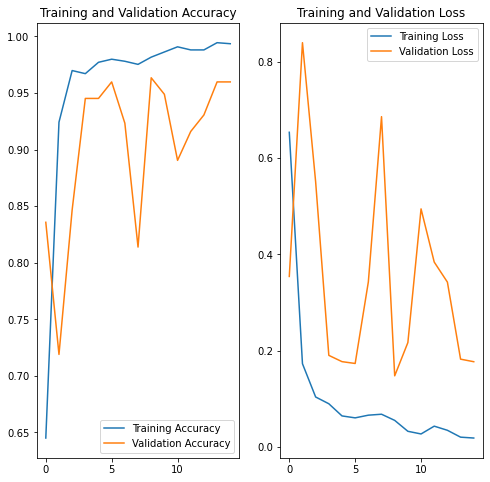

In [56]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

We can reload the model from its saved file to evaluate the test accuracy before it started overfitting. 

In [57]:
test_model = keras.models.load_model("convnet_from_scratch.keras") 
test_loss, test_acc = test_model.evaluate(test_ds) 
print(f"Test accuracy: {test_acc:.3f}")

2022-01-19 14:12:00.339361: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 8s 86ms/step - loss: 0.1489 - accuracy: 0.9459
Test accuracy: 0.946
